In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# Set visualization style
sns.set_theme(style="whitegrid", palette="colorblind")

In [2]:
pbp_py_pass_td_y = pd.read_pickle("../datasets/filtered_nfl_pass_ch6_plays.pkl")

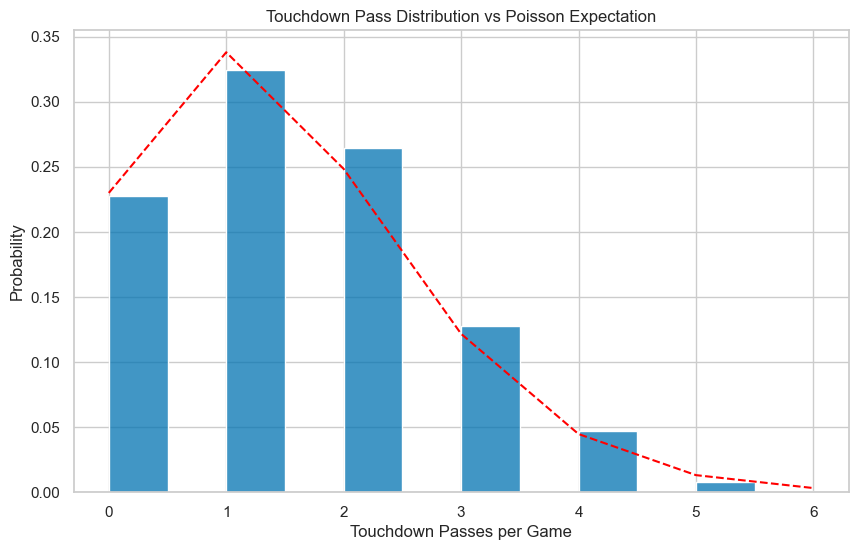

In [5]:
# ========================
# DISTRIBUTION ANALYSIS
# ========================

# Calculate Poisson probabilities
pass_td_y_mean = pbp_py_pass_td_y["pass_td_y"].mean()
x_values = range(0, 7)
poisson_probs = [poisson.pmf(x, pass_td_y_mean) for x in x_values]

# Plot distribution comparison
plt.figure(figsize=(10, 6))
sns.histplot(pbp_py_pass_td_y["pass_td_y"], stat="probability", binwidth=0.5)
plt.plot(x_values, poisson_probs, color='red', linestyle='--')
plt.title('Touchdown Pass Distribution vs Poisson Expectation')
plt.xlabel('Touchdown Passes per Game')
plt.ylabel('Probability')
plt.show()

In [6]:
# ========================
# FEATURE ENGINEERING
# ========================

# Calculate rolling touchdown rates
pbp_py_pass_td_y_geq10 = pbp_py_pass_td_y.query("n_passes >= 10")
x_py = pd.DataFrame()

for season_idx in range(2017, 2022 + 1):
    for week_idx in range(1, 22 + 1):
        # Calculate historical performance
        week_data = (
            pbp_py_pass_td_y_geq10
            .query(f"(season == {season_idx-1}) | "
                   f"(season == {season_idx} & week < {week_idx})")
            .groupby(["passer_id", "passer"])
            .agg({"pass_td_y": ["count", "mean"]})
        )
        
        # Clean and format data
        week_data.columns = list(map("_".join, week_data.columns))
        week_data = week_data.reset_index().rename(columns={
            "pass_td_y_count": "n_games",
            "pass_td_y_mean": "pass_td_rate"
        })
        week_data["season"] = season_idx
        week_data["week"] = week_idx
        
        x_py = pd.concat([x_py, week_data])


In [7]:
# ========================
# MODEL BUILDING
# ========================

# Merge features with response variable
model_data = (
    pbp_py_pass_td_y_geq10
    .query("season != 2016")
    .merge(x_py, on=["season", "week", "passer_id", "passer"], how="inner")
)

# Fit Poisson regression model
poisson_model = smf.glm(
    formula="pass_td_y ~ pass_td_rate + total_line",
    data=model_data,
    family=sm.families.Poisson()
).fit()

# Display model summary
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              pass_td_y   No. Observations:                 3297
Model:                            GLM   Df Residuals:                     3294
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4874.3
Date:                Tue, 01 Apr 2025   Deviance:                       3396.0
Time:                        11:36:35   Pearson chi2:                 2.83e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07152
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.9857      0.148     -6.646   

In [8]:
# ========================
# PREDICTION & PROBABILITY CALCULATION
# ========================

# Add predictions to data
model_data["exp_pass_td"] = poisson_model.predict()

# Calculate probability distributions
model_data["p_0_td"] = poisson.pmf(0, model_data["exp_pass_td"])
model_data["p_1_td"] = poisson.pmf(1, model_data["exp_pass_td"])
model_data["p_2_td"] = poisson.pmf(2, model_data["exp_pass_td"])
model_data["p_g2_td"] = 1 - poisson.cdf(2, model_data["exp_pass_td"])


In [9]:
# ========================
# EXAMPLE USAGE: PATRICK MAHOMES
# ========================

# Filter for specific player/game
mahomes_data = model_data.query(
    'passer == "P.Mahomes" & season == 2022 & week == 22'
)[["season", "week", "passer", "total_line", "n_games", 
   "pass_td_rate", "exp_pass_td", "p_0_td", "p_1_td", "p_2_td", "p_g2_td"]]

print("\nPatrick Mahomes Super Bowl LVII Projection:")
print(mahomes_data.to_string(index=False))



Patrick Mahomes Super Bowl LVII Projection:
 season  week    passer  total_line  n_games  pass_td_rate  exp_pass_td  p_0_td   p_1_td   p_2_td  p_g2_td
   2022    22 P.Mahomes        51.0       39      2.384615     2.108334 0.12144 0.256036 0.269905 0.352619


In [10]:
# ========================
# MODEL INTERPRETATION
# ========================

# Exponentiate coefficients for interpretation
print("\nExponentiated Coefficients:")
print(np.exp(poisson_model.params))


Exponentiated Coefficients:
Intercept       0.373173
pass_td_rate    1.358953
total_line      1.019806
dtype: float64
